In [29]:
import random
from arc_prize.synth_data.dsl import *
from arc_prize.synth_data.dsl_utils import *

def generate_ecaa0ec1() -> dict:

    def generate_example():
        # Grid size between 8x8 and 12x12
        size = random.randint(8, 12)
        height = width = size

        black = 0
        # Create a black canvas
        grid = canvas(black, (height, width))

        # Square size between 2x2 and 3x3
        square_size = random.randint(2, 3)

        # Ensure at least a 3-cell buffer around the square
        min_i = 3
        max_i = height - square_size - 3
        min_j = 3
        max_j = width - square_size - 3

        i = random.randint(min_i, max_i)
        j = random.randint(min_j, max_j)

        # Colors for the square (2-3 random colors)
        colors = random.sample(range(1, 10), random.randint(2, 3))

        # Generate square pattern using DSL functions
        square_pattern = []
        for _ in range(square_size):
            row = [random.choice(colors) for _ in range(square_size)]
            square_pattern.append(row)
        square_grid = tuple(map(tuple, square_pattern))

        # Place square onto the grid
        square_patch = toindices(asobject(square_grid))
        square_patch_shifted = shift(square_patch, (i, j))
        square_object = recolor(colors[0], square_patch_shifted)
        grid = paint(grid, square_object)

        # Indicator color (not in colors)
        indicator_color = random.choice([c for c in range(1, 10) if c not in colors])

        # Corners of the square
        square_corners = {
            'ul': (i, j),
            'ur': (i, j + square_size - 1),
            'll': (i + square_size - 1, j),
            'lr': (i + square_size - 1, j + square_size - 1)
        }

        # Choose a corner for the single indicator cell
        corner_names = list(square_corners.keys())
        corner1_name = random.choice(corner_names)
        corner1_pos = square_corners[corner1_name]

        # Place single indicator cell aligned diagonally from square corner
        step1 = random.randint(1, 3)
        di1 = -step1 if 'l' in corner1_name else step1
        dj1 = -step1 if 'u' in corner1_name else step1
        pos1_i = corner1_pos[0] + di1
        pos1_j = corner1_pos[1] + dj1

        # Ensure positions are within bounds
        pos1_i = min(max(pos1_i, 0), height - 1)
        pos1_j = min(max(pos1_j, 0), width - 1)

        # Place the single indicator cell
        grid = fill(grid, indicator_color, {(pos1_i, pos1_j)})

        # Opposite corner for three indicator cells
        corner2_name = {
            'ul': 'lr',
            'ur': 'll',
            'll': 'ur',
            'lr': 'ul'
        }[corner1_name]
        corner2_pos = square_corners[corner2_name]

        # Place three indicator cells in a corner pattern extended diagonally
        step2 = random.randint(1, 3)
        di2 = -step2 if 'l' in corner2_name else step2
        dj2 = -step2 if 'u' in corner2_name else step2

        positions = [
            (corner2_pos[0], corner2_pos[1]),  # Corner cell
            (corner2_pos[0] + di2, corner2_pos[1]),  # Vertical extension
            (corner2_pos[0], corner2_pos[1] + dj2),  # Horizontal extension
        ]

        # Ensure positions are within bounds
        positions = [
            (min(max(pi, 0), height - 1), min(max(pj, 0), width - 1))
            for pi, pj in positions
        ]

        # Place the three indicator cells
        grid = fill(grid, indicator_color, positions)

        # Save positions of the three indicator cells
        indicator_positions = positions

        # Create the output grid
        output_grid = [list(row) for row in grid]

        # Remove the three indicator cells (set to black)
        for pi, pj in indicator_positions:
            output_grid[pi][pj] = black

        # Determine rotation based on corner alignment
        rotations = {
            ('ul', 'lr'): rot180,
            ('ur', 'll'): rot180,
            ('ll', 'ur'): rot180,
            ('lr', 'ul'): rot180,
            ('ul', 'ur'): rot270,
            ('ur', 'ul'): rot90,
            ('ll', 'lr'): rot270,
            ('lr', 'll'): rot90,
            ('ul', 'll'): rot90,
            ('ll', 'ul'): rot270,
            ('ur', 'lr'): rot90,
            ('lr', 'ur'): rot270,
        }
        rotation_function = rotations.get((corner1_name, corner2_name), rot90)

        # Extract the square from the grid
        square_extracted = crop(grid, (i, j), (square_size, square_size))

        # Rotate the square using DSL functions
        rotated_square = rotation_function(square_extracted)

        # Place the rotated square back into the output grid
        for di in range(square_size):
            for dj in range(square_size):
                output_grid[i + di][j + dj] = rotated_square[di][dj]

        # Return the input and output grids as lists of lists
        input_grid = [list(row) for row in grid]
        output_grid = [list(row) for row in output_grid]

        return {'input': input_grid, 'output': output_grid}

    # Generate train examples
    train = [generate_example() for _ in range(3)]

    # Generate test examples
    test = [generate_example() for _ in range(1)]

    return {'train': train, 'test': test}


In [44]:
def generate_00576224() -> dict:
    # Define possible colors
    colors = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

    # Generate output tile size (how many times the input grid is repeated)
    output_tile_size = unifint(0, 1, (2, 3))

    # Generate number of examples (1 to 4)
    num_examples = unifint(0, 1, (1, 4))

    examples = []
    for _ in range(num_examples):
        # Generate input grid size for this example
        input_height = unifint(0, 1, (2, 4))
        input_width = unifint(0, 1, (2, 4))

        # Create input grid with random colors
        input_grid = tuple(
            tuple(choice(colors) for _ in range(input_width))
            for _ in range(input_height)
        )

        # Create output grid by tiling the input grid
        output_grid = tuple(
            tuple(input_grid[i % input_height][j % input_width] 
                  for j in range(input_width * output_tile_size))
            for i in range(input_height * output_tile_size)
        )

        examples.append({
            'input': input_grid,
            'output': output_grid
        })

    # Split examples into train and test sets
    train_size = unifint(0, 1, (1, max(1, num_examples - 1)))  # At least one example in train set
    return {
        'train': examples[:train_size],
        'test': examples[train_size:]
    }

In [2]:
import torch

x = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
y = x.pow(3).sum()

# First-order gradient
first_order = torch.autograd.grad(y, x, create_graph=True)
print(first_order)
first_order = first_order[0]

# Second-order gradient
second_order = torch.autograd.grad(first_order.sum(), x)[0]

print("First-order gradient:", first_order)
print("Second-order gradient:", second_order)

(tensor([ 3., 12., 27.], grad_fn=<MulBackward0>),)
First-order gradient: tensor([ 3., 12., 27.], grad_fn=<MulBackward0>)
Second-order gradient: tensor([ 6., 12., 18.])


In [52]:
puzzle = generate_00576224()

{'train': [{'input': ((8, 3, 6), (7, 4, 5)), 'output': ((8, 3, 6, 8, 3, 6, 8, 3, 6), (7, 4, 5, 7, 4, 5, 7, 4, 5), (8, 3, 6, 8, 3, 6, 8, 3, 6), (7, 4, 5, 7, 4, 5, 7, 4, 5), (8, 3, 6, 8, 3, 6, 8, 3, 6), (7, 4, 5, 7, 4, 5, 7, 4, 5))}], 'test': [{'input': ((5, 9, 0), (9, 1, 2), (7, 5, 1)), 'output': ((5, 9, 0, 5, 9, 0, 5, 9, 0), (9, 1, 2, 9, 1, 2, 9, 1, 2), (7, 5, 1, 7, 5, 1, 7, 5, 1), (5, 9, 0, 5, 9, 0, 5, 9, 0), (9, 1, 2, 9, 1, 2, 9, 1, 2), (7, 5, 1, 7, 5, 1, 7, 5, 1), (5, 9, 0, 5, 9, 0, 5, 9, 0), (9, 1, 2, 9, 1, 2, 9, 1, 2), (7, 5, 1, 7, 5, 1, 7, 5, 1))}, {'input': ((0, 4, 3), (7, 3, 0), (2, 4, 5)), 'output': ((0, 4, 3, 0, 4, 3, 0, 4, 3), (7, 3, 0, 7, 3, 0, 7, 3, 0), (2, 4, 5, 2, 4, 5, 2, 4, 5), (0, 4, 3, 0, 4, 3, 0, 4, 3), (7, 3, 0, 7, 3, 0, 7, 3, 0), (2, 4, 5, 2, 4, 5, 2, 4, 5), (0, 4, 3, 0, 4, 3, 0, 4, 3), (7, 3, 0, 7, 3, 0, 7, 3, 0), (2, 4, 5, 2, 4, 5, 2, 4, 5))}, {'input': ((9, 7, 2, 8), (7, 3, 8, 9), (7, 9, 9, 2)), 'output': ((9, 7, 2, 8, 9, 7, 2, 8, 9, 7, 2, 8), (7, 3, 8, 9, 7, 3

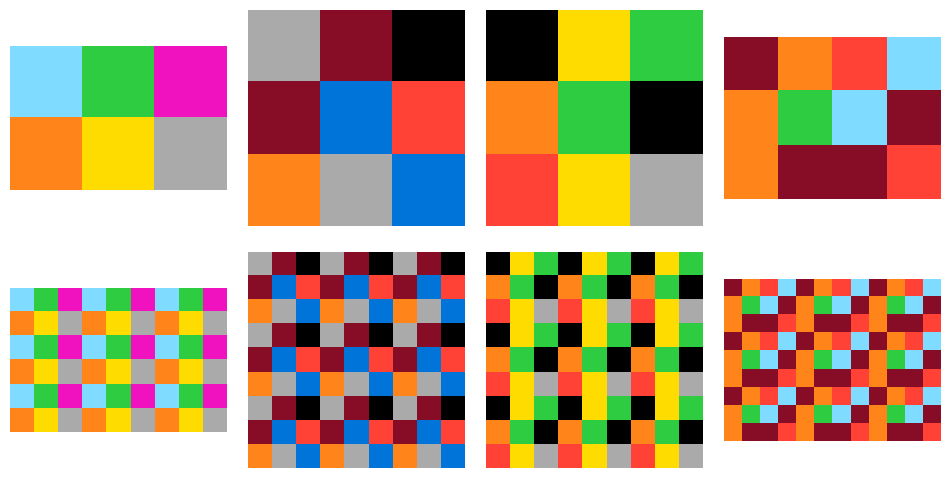

In [53]:
print(puzzle)
pairs = []
for item in puzzle["train"]:
  pairs.append(item)
for item in puzzle["test"]:
  pairs.append(item)

plot_task(pairs)